<a href="https://colab.research.google.com/github/saxena07/Google-Colab-Python/blob/main/A1_19102026_Lakshya_Saxena_lab_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

Experiment Number 8
==============================
Aim : To perform the following operations on Digital Image in Spatial Domain  Rescale, resize, and downscale of image
==============================

`Rescale` operation resizes an image by a given scaling factor. The scaling
factor can either be a single floating point value, or multiple values - one
along each axis.

`Resize` serves the same purpose, but allows to specify an output image shape
instead of a scaling factor.

Note that when down-sampling an image, `resize` and `rescale` should perform
Gaussian smoothing to avoid aliasing artifacts. See the `anti_aliasing` and
`anti_aliasing_sigma` arguments to these functions.

`Downscale` serves the purpose of down-sampling an n-dimensional image by
integer factors using the local mean on the elements of each block of the size
factors given as a parameter to the function.


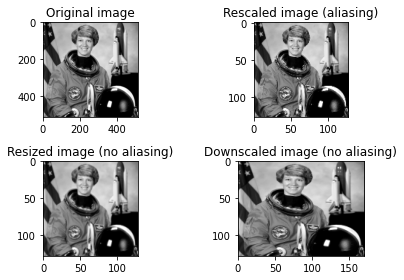

In [ ]:
import matplotlib.pyplot as plt

from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

image = color.rgb2gray(data.astronaut())

image_rescaled = rescale(image, 0.25, anti_aliasing=False)
image_resized = resize(image, (image.shape[0] // 4, image.shape[1] // 4),
                       anti_aliasing=True)
image_downscaled = downscale_local_mean(image, (4, 3))

fig, axes = plt.subplots(nrows=2, ncols=2)

ax = axes.ravel()

ax[0].imshow(image, cmap='gray')
ax[0].set_title("Original image")

ax[1].imshow(image_rescaled, cmap='gray')
ax[1].set_title("Rescaled image (aliasing)")

ax[2].imshow(image_resized, cmap='gray')
ax[2].set_title("Resized image (no aliasing)")

ax[3].imshow(image_downscaled, cmap='gray')
ax[3].set_title("Downscaled image (no aliasing)")

ax[0].set_xlim(0, 512)
ax[0].set_ylim(512, 0)
plt.tight_layout()
plt.show()

In [ ]:
%matplotlib inline


# 8.2 Filtering regional maxima


Here, we use morphological reconstruction to create a background image, which
we can subtract from the original image to isolate bright features (regional
maxima).

First we try reconstruction by dilation starting at the edges of the image. We
initialize a seed image to the minimum intensity of the image, and set its
border to be the pixel values in the original image. These maximal pixels will
get dilated in order to reconstruct the background image.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter
from skimage import data
from skimage import img_as_float
from skimage.morphology import reconstruction

# Convert to float: Important for subtraction later which won't work with uint8
image = img_as_float(data.coins())
image = gaussian_filter(image, 1)

seed = np.copy(image)
seed[1:-1, 1:-1] = image.min()
mask = image

dilated = reconstruction(seed, mask, method='dilation')

Subtracting the dilated image leaves an image with just the coins and a
flat, black background, as shown below.



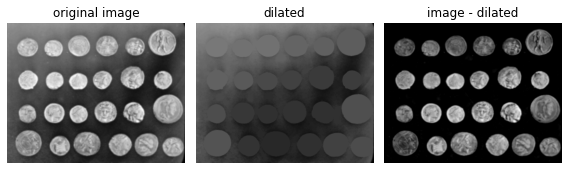

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1,
                                    ncols=3,
                                    figsize=(8, 2.5),
                                    sharex=True,
                                    sharey=True)

ax0.imshow(image, cmap='gray')
ax0.set_title('original image')
ax0.axis('off')

ax1.imshow(dilated, vmin=image.min(), vmax=image.max(), cmap='gray')
ax1.set_title('dilated')
ax1.axis('off')

ax2.imshow(image - dilated, cmap='gray')
ax2.set_title('image - dilated')
ax2.axis('off')

fig.tight_layout()

Although the features (i.e. the coins) are clearly isolated, the coins
surrounded by a bright background in the original image are dimmer in the
subtracted image. We can attempt to correct this using a different seed
image.

Instead of creating a seed image with maxima along the image border, we can
use the features of the image itself to seed the reconstruction process.
Here, the seed image is the original image minus a fixed value, ``h``.



In [ ]:
h = 0.4
seed = image - h
dilated = reconstruction(seed, mask, method='dilation')
hdome = image - dilated

To get a feel for the reconstruction process, we plot the intensity of the
mask, seed, and dilated images along a slice of the image (indicated by red
line).



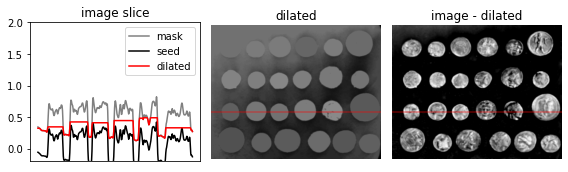

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(8, 2.5))
yslice = 197

ax0.plot(mask[yslice], '0.5', label='mask')
ax0.plot(seed[yslice], 'k', label='seed')
ax0.plot(dilated[yslice], 'r', label='dilated')
ax0.set_ylim(-0.2, 2)
ax0.set_title('image slice')
ax0.set_xticks([])
ax0.legend()

ax1.imshow(dilated, vmin=image.min(), vmax=image.max(), cmap='gray')
ax1.axhline(yslice, color='r', alpha=0.4)
ax1.set_title('dilated')
ax1.axis('off')

ax2.imshow(hdome, cmap='gray')
ax2.axhline(yslice, color='r', alpha=0.4)
ax2.set_title('image - dilated')
ax2.axis('off')

fig.tight_layout()
plt.show()

As you can see in the image slice, each coin is given a different baseline
intensity in the reconstructed image; this is because we used the local
intensity (shifted by ``h``) as a seed value. As a result, the coins in the
subtracted image have similar pixel intensities. The final result is known
as the h-dome of an image since this tends to isolate regional maxima of
height ``h``. This operation is particularly useful when your images are
unevenly illuminated.



In [ ]:
%matplotlib inline


# 8.3  Mean filters


This example compares the following mean filters of the rank filter package:

* **local mean**: all pixels belonging to the structuring element to compute
  average gray level.
* **percentile mean**: only use values between percentiles p0 and p1
  (here 10% and 90%).
* **bilateral mean**: only use pixels of the structuring element having a gray
  level situated inside g-s0 and g+s1 (here g-500 and g+500)

Percentile and usual mean give here similar results, these filters smooth the
complete image (background and details). Bilateral mean exhibits a high
filtering rate for continuous area (i.e. background) while higher image
frequencies remain untouched.


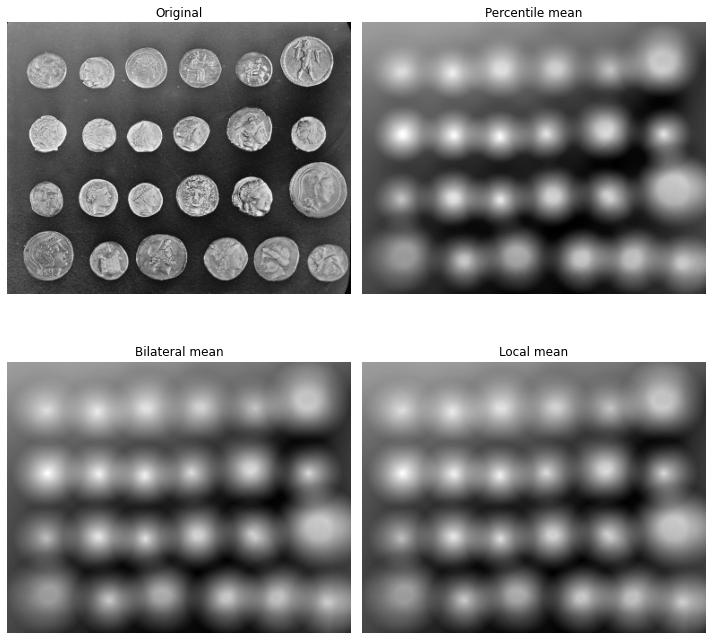

In [ ]:
import matplotlib.pyplot as plt

from skimage import data
from skimage.morphology import disk
from skimage.filters import rank


image = data.coins()
selem = disk(20)

percentile_result = rank.mean_percentile(image, selem=selem, p0=.1, p1=.9)
bilateral_result = rank.mean_bilateral(image, selem=selem, s0=500, s1=500)
normal_result = rank.mean(image, selem=selem)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10),
                         sharex=True, sharey=True)
ax = axes.ravel()

titles = ['Original', 'Percentile mean', 'Bilateral mean', 'Local mean']
imgs = [image, percentile_result, bilateral_result, normal_result]
for n in range(0, len(imgs)):
    ax[n].imshow(imgs[n], cmap=plt.cm.gray)
    ax[n].set_title(titles[n])
    ax[n].axis('off')

plt.tight_layout()
plt.show()

# 8.4 In Lab  Practice Exersise 

In [ ]:
%matplotlib inline


#  8.4 In Lab Exersise : Edge operators


Edge operators are used in image processing within edge detection algorithms.
They are discrete differentiation operators, computing an approximation of the
gradient of the image intensity function.


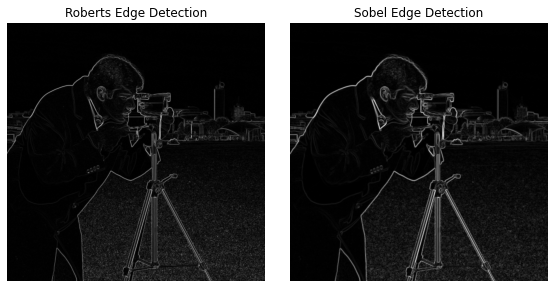

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import filters
from skimage.data import camera
from skimage.util import compare_images


image = camera()
edge_roberts = filters.roberts(image)
edge_sobel = filters.sobel(image)

fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True,
                         figsize=(8, 4))

axes[0].imshow(edge_roberts, cmap=plt.cm.gray)
axes[0].set_title('Roberts Edge Detection')

axes[1].imshow(edge_sobel, cmap=plt.cm.gray)
axes[1].set_title('Sobel Edge Detection')

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

Different operators compute different finite-difference approximations of
the gradient. For example, the Scharr filter results in a less rotational
variance than the Sobel filter that is in turn better than the Prewitt
filter [1]_ [2]_ [3]_. The difference between the Prewitt and Sobel filters
and the Scharr filter is illustrated below with an image that is the
discretization of a rotation- invariant continuous function. The
discrepancy between the Prewitt and Sobel filters, and the Scharr filter is
stronger for regions of the image where the direction of the gradient is
close to diagonal, and for regions with high spatial frequencies. For the
example image the differences between the filter results are very small and
the filter results are visually almost indistinguishable.

.. [1] https://en.wikipedia.org/wiki/Sobel_operator#Alternative_operators

.. [2] B. Jaehne, H. Scharr, and S. Koerkel. Principles of filter design.
       In Handbook of Computer Vision and Applications. Academic Press,
       1999.

.. [3] https://en.wikipedia.org/wiki/Prewitt_operator



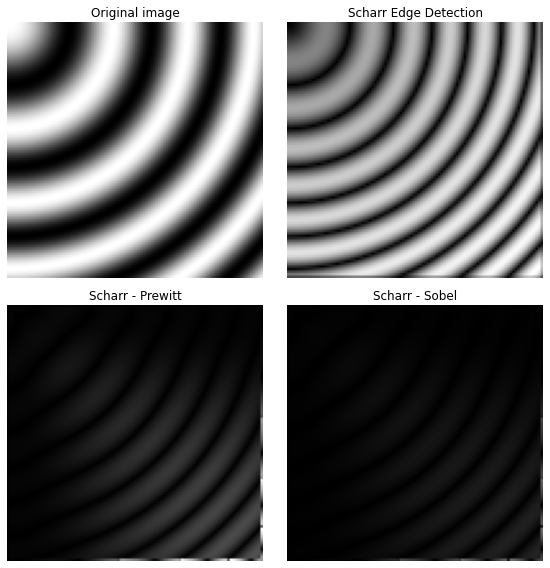

In [ ]:
x, y = np.ogrid[:100, :100]

# Creating a rotation-invariant image with different spatial frequencies.
image_rot = np.exp(1j * np.hypot(x, y) ** 1.3 / 20.).real

edge_sobel = filters.sobel(image_rot)
edge_scharr = filters.scharr(image_rot)
edge_prewitt = filters.prewitt(image_rot)

diff_scharr_prewitt = compare_images(edge_scharr, edge_prewitt)
diff_scharr_sobel = compare_images(edge_scharr, edge_sobel)
max_diff = np.max(np.maximum(diff_scharr_prewitt, diff_scharr_sobel))

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True,
                         figsize=(8, 8))
axes = axes.ravel()

axes[0].imshow(image_rot, cmap=plt.cm.gray)
axes[0].set_title('Original image')

axes[1].imshow(edge_scharr, cmap=plt.cm.gray)
axes[1].set_title('Scharr Edge Detection')

axes[2].imshow(diff_scharr_prewitt, cmap=plt.cm.gray, vmax=max_diff)
axes[2].set_title('Scharr - Prewitt')

axes[3].imshow(diff_scharr_sobel, cmap=plt.cm.gray, vmax=max_diff)
axes[3].set_title('Scharr - Sobel')

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

As in the previous example, here we illustrate the rotational invariance of
the filters. The top row shows a rotationally invariant image along with the
angle of its analytical gradient. The other two rows contain the difference
between the different gradient approximations (Sobel, Prewitt, Scharr &
Farid) and analytical gradient.

The Farid & Simoncelli derivative filters [4]_, [5]_  are the most
rotationally invariant, but require a 5x5 kernel, which is computationally
more intensive than a 3x3 kernel.

.. [4] Farid, H. and Simoncelli, E. P., "Differentiation of discrete
       multidimensional signals", IEEE Transactions on Image Processing
       13(4): 496-508, 2004. :DOI:`10.1109/TIP.2004.823819`

.. [5] Wikipedia, "Farid and Simoncelli Derivatives." Available at:
       <https://en.wikipedia.org/wiki/Image_derivatives#Farid_and_Simoncelli_Derivatives>



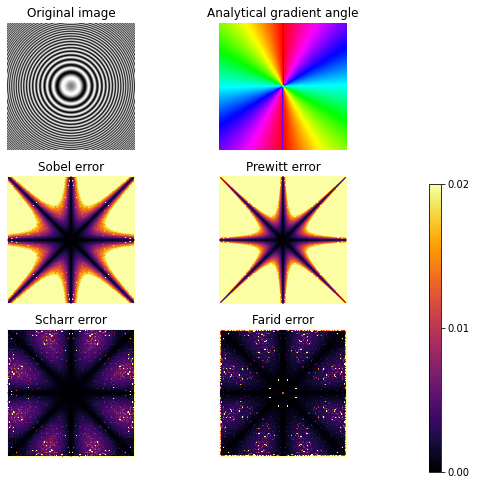

In [ ]:
x, y = np.mgrid[-10:10:255j, -10:10:255j]
image_rotinv = np.sin(x ** 2 + y ** 2)

image_x = 2 * x * np.cos(x ** 2 + y ** 2)
image_y = 2 * y * np.cos(x ** 2 + y ** 2)

def angle(dx, dy):
    """Calculate the angles between horizontal and vertical operators."""
    return np.mod(np.arctan2(dy, dx), np.pi)


true_angle = angle(image_x, image_y)

angle_farid = angle(filters.farid_h(image_rotinv),
                    filters.farid_v(image_rotinv))
angle_sobel = angle(filters.sobel_h(image_rotinv),
                    filters.sobel_v(image_rotinv))
angle_scharr = angle(filters.scharr_h(image_rotinv),
                     filters.scharr_v(image_rotinv))
angle_prewitt = angle(filters.prewitt_h(image_rotinv),
                      filters.prewitt_v(image_rotinv))

def diff_angle(angle_1, angle_2):
    """Calculate the differences between two angles."""
    return np.minimum(np.pi - np.abs(angle_1 - angle_2),
                      np.abs(angle_1 - angle_2))


diff_farid = diff_angle(true_angle, angle_farid)
diff_sobel = diff_angle(true_angle, angle_sobel)
diff_scharr = diff_angle(true_angle, angle_scharr)
diff_prewitt = diff_angle(true_angle, angle_prewitt)

fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True,
                         figsize=(8, 8))
axes = axes.ravel()

axes[0].imshow(image_rotinv, cmap=plt.cm.gray)
axes[0].set_title('Original image')

axes[1].imshow(true_angle, cmap=plt.cm.hsv)
axes[1].set_title('Analytical gradient angle')

axes[2].imshow(diff_sobel, cmap=plt.cm.inferno, vmin=0, vmax=0.02)
axes[2].set_title('Sobel error')

axes[3].imshow(diff_prewitt, cmap=plt.cm.inferno, vmin=0, vmax=0.02)
axes[3].set_title('Prewitt error')

axes[4].imshow(diff_scharr, cmap=plt.cm.inferno, vmin=0, vmax=0.02)
axes[4].set_title('Scharr error')

color_ax = axes[5].imshow(diff_farid, cmap=plt.cm.inferno, vmin=0, vmax=0.02)
axes[5].set_title('Farid error')

fig.subplots_adjust(right=0.8)
colorbar_ax = fig.add_axes([0.90, 0.10, 0.02, 0.50])
fig.colorbar(color_ax, cax=colorbar_ax, ticks=[0, 0.01, 0.02])

for ax in axes:
    ax.axis('off')

plt.show()

# 8.5 Post Lab Execrise 
#Check is it possible to perform background and Foreground extraction using the above techniques ?

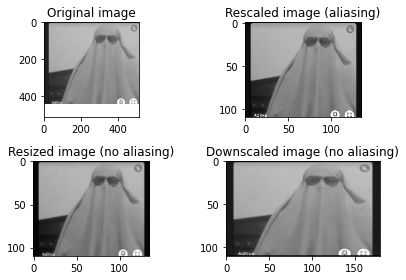

In [ ]:
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg # since we cannt paste path of img in rgb2grey

from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

import skimage.io as io
image1 = io.imread("img1.jpeg")

image = color.rgb2gray(image1)

#img = mpimg.imread("first.jpg")

#image = color.rgb2gray(/content/Coffee Mugs to Match Your Personal Style _ Society6.jfif)

image_rescaled = rescale(image, 0.25, anti_aliasing=False)
image_resized = resize(image, (image.shape[0] // 4, image.shape[1] // 4),
                       anti_aliasing=True)
image_downscaled = downscale_local_mean(image, (4, 3))

fig, axes = plt.subplots(nrows=2, ncols=2)

ax = axes.ravel()

ax[0].imshow(image, cmap='gray')
ax[0].set_title("Original image")

ax[1].imshow(image_rescaled, cmap='gray')
ax[1].set_title("Rescaled image (aliasing)")

ax[2].imshow(image_resized, cmap='gray')
ax[2].set_title("Resized image (no aliasing)")

ax[3].imshow(image_downscaled, cmap='gray')
ax[3].set_title("Downscaled image (no aliasing)")

ax[0].set_xlim(0, 512)
ax[0].set_ylim(512, 0)
plt.tight_layout()
plt.show()